In [1]:
import os
from pathlib import Path
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 11 (Query Construction)"

In [4]:
DATA_PATH = Path('../../data')
VECTORSTORE_PATH = DATA_PATH / 'vectorstore/chroma'

# Query construction

![](images/query-construction-01.png)

# Part 11: Query Construction

## Configure components

In [5]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKOqGHVu0Kk43L2v3ZZTrFqY1muxF', 'finish_reason': 'stop', 'logprobs': None}, id='run-36bcf9f6-cfab-45b0-976b-669a7e7f6cb0-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [8]:
import asyncio

from langchain_community.document_loaders import YoutubeLoader
from pytube import Playlist
from pytube.innertube import _default_clients

In [9]:
# https://github.com/pytube/pytube/issues/1894#issue-2180600881
_default_clients["ANDROID"]["context"]["client"]["clientVersion"] = "19.08.35"

In [10]:
playlist = Playlist('https://www.youtube.com/playlist?list=PLfaIDFEXuae2LXbO1_PKyVJiQ23ZztA0x')
print(playlist.title)
print(playlist.video_urls)

RAG From Scratch
['https://www.youtube.com/watch?v=wd7TZ4w1mSw', 'https://www.youtube.com/watch?v=bjb_EMsTDKI', 'https://www.youtube.com/watch?v=LxNVgdIz9sU', 'https://www.youtube.com/watch?v=Vw52xyyFsB8', 'https://www.youtube.com/watch?v=JChPi0CRnDY', 'https://www.youtube.com/watch?v=77qELPbNgxA', 'https://www.youtube.com/watch?v=h0OPWlEOank', 'https://www.youtube.com/watch?v=xn1jEjRyJ2U', 'https://www.youtube.com/watch?v=SaDzIVkYqyY', 'https://www.youtube.com/watch?v=pfpIndq7Fi8', 'https://www.youtube.com/watch?v=kl6NwWYxvbM', 'https://www.youtube.com/watch?v=gTCU9I6QqCE', 'https://www.youtube.com/watch?v=z_6EeA2LDSw', 'https://www.youtube.com/watch?v=cN6S0Ehm7_8']


In [11]:
async def load_youtube_video_transcript(video_url):
    data = await YoutubeLoader.from_youtube_url(
        video_url, 
        add_video_info=True
    ).aload()
    return data[0]

In [12]:
coros = [load_youtube_video_transcript(video_url) for video_url in playlist.video_urls]
docs = await asyncio.gather(*coros)
len(docs)

14

In [13]:
docs[0].metadata

{'source': 'wd7TZ4w1mSw',
 'title': 'RAG From Scratch: Part 1 (Overview)',
 'description': 'LLMs are a powerful new platform, but they are not always trained on data that is relevant for our tasks. This is where retrieval augmented generation (or RAG) comes in: RAG is a general methodology for connecting LLMs with external data sources such as private or recent data. It allows LLMs to use external data in generation of their output. This video series will build up an understanding of RAG from scratch, starting with the basics of indexing, retrieval, and generation. It will build up to more advanced techniques to address edge cases or challenges in RAG. \n\nCode: \nhttps://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb\n\nSlides:\nhttps://docs.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing',
 'view_count': 141730,
 'thumbnail_url': 'https://i.ytimg.com/vi/wd7TZ4w1mSw/sddefault.jpg',
 'publish_date': '2024-02-06 0

In [14]:
print(docs[0].page_content[:1000])

hi this is Lance from Lang chain we're starting a new series called rag from scratch that's going to walk through some of the basic principles for Rag and kind of build up to Advanced topics um so one of the main motivations for rag is simply that llms haven't seen all of the data that you may care about so like private data or very recent data would not be included in the pre-training Run for these LMS and you can see here on the graph on the xaxis that the number of tokens that they're pre-trained on which is of course very large um but of course it's still always going to be limited relative to private data that you care about or for example recent data but there's another interesting consideration is that llms have context windows that are actually getting increasingly large so you know coming going from like thousands of tokens to many thousands of tokens which represents you know dozens of Pages up to hundreds of pages we can fit information into them from external sources and a 

## Split documents

In [15]:
from datetime import datetime
import shutil

from langchain.text_splitter import RecursiveCharacterTextSplitter

In [16]:
def generate_chunk_content(chunk):
    return "\n\n".join([
        f"Title:\n{chunk.metadata['title']}",
        f"Description:\n{chunk.metadata['description']}",
        f"Transcript:\n{chunk.page_content}"
    ])

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=8000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

14

In [18]:
rprint(splits[0])
print(splits[0].page_content)

Document(
    metadata={
        'source': 'wd7TZ4w1mSw',
        'title': 'RAG From Scratch: Part 1 (Overview)',
        'description': 'LLMs are a powerful new platform, but they are not always trained on data that is relevant 
for our tasks. This is where retrieval augmented generation (or RAG) comes in: RAG is a general methodology for 
connecting LLMs with external data sources such as private or recent data. It allows LLMs to use external data in 
generation of their output. This video series will build up an understanding of RAG from scratch, starting with the
basics of indexing, retrieval, and generation. It will build up to more advanced techniques to address edge cases 
or challenges in RAG. \n\nCode: 
\nhttps://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb\n\nSlides:\nhttps://docs
.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing',
        'view_count': 141730,
        'thumbnail_url': 'https://i.ytimg.com/vi/wd7TZ4w1mSw/sddefault.jpg',
        'publish_date': '2024-02-06 00:00:00',
        'length': 313,
        'author': 'LangChain'
    },
    page_content="hi this is Lance from Lang chain we're starting a new series called rag from scratch that's going
to walk through some of the basic principles for Rag and kind of build up to Advanced topics um so one of the main 
motivations for rag is simply that llms haven't seen all of the data that you may care about so like private data 
or very recent data would not be included in the pre-training Run for these LMS and you can see here on the graph 
on the xaxis that the number of tokens that they're pre-trained on which is of course very large um but of course 
it's still always going to be limited relative to private data that you care about or for example recent data but 
there's another interesting consideration is that llms have context windows that are actually getting increasingly 
large so you know coming going from like thousands of tokens to many thousands of tokens which represents you know 
dozens of Pages up to hundreds of pages we can fit information into them from external sources and a way to think 
about this is llms are kind of a a kernel of a new kind of operating system and connecting them to external data is
kind of a very Central capability in the development of this kind new emergent operating system so retrieval alment
to generation or rag is a very popular kind of General Paradigm for doing this which typically involves three 
stages so the first stage is indexing some external documents such that they can be easily retrieved based on an 
input query so for example we ask a question we retrieve documents that are relevant to that question we feed those
documents into an llm in the final generation stage to produce an answer that's grounded in those retrieve 
documents now we're starting from scratch but we're going to kind of build up to this broader view of rag you can 
see here there's a lot of interesting methods and tricks that kind of fan out from those three basic components of 
indexing retrieval and generation and future videos are actually going to walk through those in detail we're going 
to try to keep each video pretty short like five minutes but we're going to spend a lot of time on some of those 
more advanced topics first over the next three videos I'll just be laying out the very basic kind of ideas behind 
indexing retrieval and generation and then we'll kind of build beyond that into those more advanced themes and now 
I want to show just a quick code walkth through because we want to make these videos also a little bit interactive 
so right here and this repo will be shared it's public I have a a notebook open and I've just just basically 
installed a few packages and I've set a few environment variables for my lsmith keys which um I personally do 
recommend it's really useful for tracing observability um particularly when you're building rag pipelines so

hi this is Lance from Lang chain we're starting a new series called rag from scratch that's going to walk through some of the basic principles for Rag and kind of build up to Advanced topics um so one of the main motivations for rag is simply that llms haven't seen all of the data that you may care about so like private data or very recent data would not be included in the pre-training Run for these LMS and you can see here on the graph on the xaxis that the number of tokens that they're pre-trained on which is of course very large um but of course it's still always going to be limited relative to private data that you care about or for example recent data but there's another interesting consideration is that llms have context windows that are actually getting increasingly large so you know coming going from like thousands of tokens to many thousands of tokens which represents you know dozens of Pages up to hundreds of pages we can fit information into them from external sources and a 

In [19]:
print(generate_chunk_content(splits[0]))

Title:
RAG From Scratch: Part 1 (Overview)

Description:
LLMs are a powerful new platform, but they are not always trained on data that is relevant for our tasks. This is where retrieval augmented generation (or RAG) comes in: RAG is a general methodology for connecting LLMs with external data sources such as private or recent data. It allows LLMs to use external data in generation of their output. This video series will build up an understanding of RAG from scratch, starting with the basics of indexing, retrieval, and generation. It will build up to more advanced techniques to address edge cases or challenges in RAG. 

Code: 
https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb

Slides:
https://docs.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing

Transcript:
hi this is Lance from Lang chain we're starting a new series called rag from scratch that's going to walk through some of the basic principles for Rag an

In [20]:
datetime_format = '%Y-%m-%d %H:%M:%S'
date_format = '%Y%m%d'

processed_splits = []

for split in splits:
    processed_split = split.copy()
    processed_split.metadata['publish_date'] = int(datetime.strptime(processed_split.metadata['publish_date'], datetime_format).strftime(date_format))
    processed_split.page_content = generate_chunk_content(processed_split)
    processed_splits.append(processed_split)

len(processed_splits)

/tmp/ipykernel_271480/3296768915.py:7: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  processed_split = split.copy()


14

In [21]:
rprint(processed_splits[0])
print(processed_splits[0].page_content)

Document(
    metadata={
        'source': 'wd7TZ4w1mSw',
        'title': 'RAG From Scratch: Part 1 (Overview)',
        'description': 'LLMs are a powerful new platform, but they are not always trained on data that is relevant 
for our tasks. This is where retrieval augmented generation (or RAG) comes in: RAG is a general methodology for 
connecting LLMs with external data sources such as private or recent data. It allows LLMs to use external data in 
generation of their output. This video series will build up an understanding of RAG from scratch, starting with the
basics of indexing, retrieval, and generation. It will build up to more advanced techniques to address edge cases 
or challenges in RAG. \n\nCode: 
\nhttps://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb\n\nSlides:\nhttps://docs
.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing',
        'view_count': 141730,
        'thumbnail_url': 'https://i.ytimg.com/vi/wd7TZ4w1mSw/sddefault.jpg',
        'publish_date': 20240206,
        'length': 313,
        'author': 'LangChain'
    },
    page_content="Title:\nRAG From Scratch: Part 1 (Overview)\n\nDescription:\nLLMs are a powerful new platform, 
but they are not always trained on data that is relevant for our tasks. This is where retrieval augmented 
generation (or RAG) comes in: RAG is a general methodology for connecting LLMs with external data sources such as 
private or recent data. It allows LLMs to use external data in generation of their output. This video series will 
build up an understanding of RAG from scratch, starting with the basics of indexing, retrieval, and generation. It 
will build up to more advanced techniques to address edge cases or challenges in RAG. \n\nCode: 
\nhttps://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb\n\nSlides:\nhttps://docs
.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing\n\nTranscript:\nhi this is
Lance from Lang chain we're starting a new series called rag from scratch that's going to walk through some of the 
basic principles for Rag and kind of build up to Advanced topics um so one of the main motivations for rag is 
simply that llms haven't seen all of the data that you may care about so like private data or very recent data 
would not be included in the pre-training Run for these LMS and you can see here on the graph on the xaxis that the
number of tokens that they're pre-trained on which is of course very large um but of course it's still always going
to be limited relative to private data that you care about or for example recent data but there's another 
interesting consideration is that llms have context windows that are actually getting increasingly large so you 
know coming going from like thousands of tokens to many thousands of tokens which represents you know dozens of 
Pages up to hundreds of pages we can fit information into them from external sources and a way to think about this 
is llms are kind of a a kernel of a new kind of operating system and connecting them to external data is kind of a 
very Central capability in the development of this kind new emergent operating system so retrieval alment to 
generation or rag is a very popular kind of General Paradigm for doing this which typically involves three stages 
so the first stage is indexing some external documents such that they can be easily retrieved based on an input 
query so for example we ask a question we retrieve documents that are relevant to that question we feed those 
documents into an llm in the final generation stage to produce an answer that's grounded in those retrieve 
documents now we're starting from scratch but we're going to kind of build up to this broader view of rag you can 
see here there's a lot of interesting methods and tricks that kind of fan out from those three basic components of 
indexing retrieval and generation and future video

Title:
RAG From Scratch: Part 1 (Overview)

Description:
LLMs are a powerful new platform, but they are not always trained on data that is relevant for our tasks. This is where retrieval augmented generation (or RAG) comes in: RAG is a general methodology for connecting LLMs with external data sources such as private or recent data. It allows LLMs to use external data in generation of their output. This video series will build up an understanding of RAG from scratch, starting with the basics of indexing, retrieval, and generation. It will build up to more advanced techniques to address edge cases or challenges in RAG. 

Code: 
https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb

Slides:
https://docs.google.com/presentation/d/1C9IaAwHoWcc4RSTqo-pCoN3h0nCgqV2JEYZUJunv_9Q/edit?usp=sharing

Transcript:
hi this is Lance from Lang chain we're starting a new series called rag from scratch that's going to walk through some of the basic principles for Rag an

## Store documents

In [22]:
import chromadb
from chromadb.config import Settings
from langchain_chroma import Chroma

In [23]:
def get_collection_size(vectorstore):
    try:
        collection_size = len(vectorstore.get()["ids"])
    except Exception as _:
        collection_size = 0

    return collection_size

In [24]:
collection_name="youtube-rag-from-scratch"

In [25]:
vectorstore_settings = Settings(anonymized_telemetry=False)
client = chromadb.PersistentClient(
    path=str(VECTORSTORE_PATH), settings=vectorstore_settings
)

Chroma(collection_name=collection_name, client=client).delete_collection()

vectorstore = Chroma(
    collection_name=collection_name, embedding_function=embeddings, client=client
)

doc_ids = vectorstore.add_documents(documents=processed_splits)
len(doc_ids), get_collection_size(vectorstore)

(14, 14)

## Configure self-query retriever

![](images/11-self-query.jpg)

In [26]:
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.query_constructors.chroma import ChromaTranslator

In [27]:
def clean_json_string(message):
    pattern = r".*?```json\s*(.*?)\s*```"
    cleaned_string = re.sub(pattern, r"\1", message.content, flags=re.DOTALL | re.IGNORECASE)
    return cleaned_string.strip()

In [28]:
translator = ChromaTranslator()

print(translator.allowed_comparators)
print(translator.allowed_operators)

[<Comparator.EQ: 'eq'>, <Comparator.NE: 'ne'>, <Comparator.GT: 'gt'>, <Comparator.GTE: 'gte'>, <Comparator.LT: 'lt'>, <Comparator.LTE: 'lte'>]
[<Operator.AND: 'and'>, <Operator.OR: 'or'>]


In [29]:
document_content_description = "Tutorial videos about RAG"

metadata_field_info = [
    AttributeInfo(
        name="view_count",
        description="Video views count",
        type="integer",
    ),
    AttributeInfo(
        name="publish_date",
        description="Video publish date in format YYYYMMDD",
        type="int",
    ),
    AttributeInfo(
        name="length",
        description="Video length (seconds)",
        type="float",
    ),
]

examples = [
    (
        "Find videos under 5 minutes",
        {
            "query": "Videos with length less than 300 seconds",
            "filter": 'lt("length", 300.0)',
        }
    ),
    (
        "Find videos published in 2024",
        {
            "query": "Videos with date greater or equal than 2024-01-01 and less than 2025-01-01",
            "filter": 'and(gte("publish_date", 20240101), lt("publish_date", 20250101))'
        }
    ),
    (
        "Find videos about indexing",
        {
            "query": "Videos about indexing",
            "filter": "NO_FILTER"
        }
    ),
    (
        "Find 3 videos about indexing",
        {
            "query": "3 videos about indexing",
            "filter": "NO_FILTER",
            "limit": 3
        }
    ),
]

In [30]:
query_constructor_prompt = get_query_constructor_prompt(
    document_content_description,
    metadata_field_info,
    examples=examples,
    allowed_comparators=translator.allowed_comparators,
    allowed_operators=translator.allowed_operators,
    enable_limit=True
)

query_constructor_prompt.pretty_print()

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
    "limit": int \ the number of documents to retrieve
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ..

In [31]:
output_parser = StructuredQueryOutputParser.from_components(
    allowed_comparators=translator.allowed_comparators,
    allowed_operators=translator.allowed_operators
)
rprint(output_parser)

StructuredQueryOutputParser(
    ast_parse=<bound method Lark.parse of Lark(open('<string>'), parser='lalr', lexer='contextual', ...)>
)

## RAG

In [32]:
from typing import TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from langgraph.graph import END, START, StateGraph

In [33]:
questions = [
    "Which videos are 7 to 10 minutes long",
    "Videos published in March 2024",
    "Find tutorials with views not less than 100k",
    "Which videos should I watch on the topic of routing",
    "Which 1 video should I watch on the topic of routing"
]

In [34]:
@chain
def query_constructor(query):
    query_constructor_prompt_messages = query_constructor_prompt.format(query=query)
    response = llm.invoke([
        HumanMessage(content=query_constructor_prompt_messages)
    ])
    clean_response = clean_json_string(response)
    parsed_response = output_parser.invoke(clean_response)
    return parsed_response

In [35]:
for question in questions:
    print(question)
    response = query_constructor.invoke(question)
    rprint(response)

Which videos are 7 to 10 minutes long


StructuredQuery(
    query='Videos with length between 420 seconds and 600 seconds',
    filter=Operation(
        operator=<Operator.AND: 'and'>,
        arguments=[
            Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='length', value=420.0),
            Comparison(comparator=<Comparator.LTE: 'lte'>, attribute='length', value=600.0)
        ]
    ),
    limit=None
)

Videos published in March 2024


StructuredQuery(
    query='Videos with publish date in March 2024',
    filter=Operation(
        operator=<Operator.AND: 'and'>,
        arguments=[
            Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='publish_date', value=20240301),
            Comparison(comparator=<Comparator.LT: 'lt'>, attribute='publish_date', value=20240401)
        ]
    ),
    limit=None
)

Find tutorials with views not less than 100k


StructuredQuery(
    query='Tutorials with view count not less than 100000',
    filter=Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='view_count', value=100000),
    limit=None
)

Which videos should I watch on the topic of routing


StructuredQuery(query='Videos on the topic of routing', filter=None, limit=None)

Which 1 video should I watch on the topic of routing


StructuredQuery(query='Videos on the topic of routing', filter=None, limit=1)

In [36]:
retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vectorstore,
    structured_query_translator=translator,
    verbose=True,
    search_kwargs={'k': len(processed_splits)}
)

In [37]:
class State(TypedDict):
    question: str
    context: list[Document]

In [38]:
def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

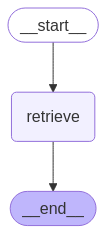

In [39]:
graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", END)

graph = graph_builder.compile()
graph

In [40]:
for question in questions:
    print(question)
    response = graph.invoke({"question": question})
    rprint(Pretty(response, max_string=100, no_wrap=False))

Which videos are 7 to 10 minutes long


{
    'question': 'Which videos are 7 to 10 minutes long',
    'context': [
        Document(
            id='9504d965-313e-4d44-9990-ed78146534f8',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1588,
                'length': 432,
                'publish_date': 20240330,
                'source': 'cN6S0Ehm7_8',
                'thumbnail_url': 'https://i.ytimg.com/vi/cN6S0Ehm7_8/sddefault.jpg',
                'title': 'RAG From Scratch: Part 14 (ColBERT)',
                'view_count': 15852
            },
            page_content='Title:\nRAG From Scratch: Part 14 (ColBERT)\n\nDescription:\nOur RAG From Scratch video 
series walks thr'+8822
        ),
        Document(
            id='5d1546a8-58d7-4729-b3ed-64c8c72de4c7',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1026,
                'length': 460,
                'publish_date': 20240329,
                'source': 'z_6EeA2LDSw',
                'thumbnail_url': 'https://i.ytimg.com/vi/z_6EeA2LDSw/sddefault.jpg',
                'title': 'RAG From Scratch: Part 13 (RAPTOR)',
                'view_count': 15310
            },
            page_content='Title:\nRAG From Scratch: Part 13 (RAPTOR)\n\nDescription:\nOur RAG From Scratch video 
series walks thro'+8444
        ),
        Document(
            id='070071c3-8f7f-4413-8a1e-699fe4a21510',
            metadata={
                'author': 'LangChain',
                'description': 'This is the 10th video in our RAG From Scratch series, focused on different types 
of query routing ('+235,
                'length': 422,
                'publish_date': 20240318,
                'source': 'pfpIndq7Fi8',
                'thumbnail_url': 'https://i.ytimg.com/vi/pfpIndq7Fi8/sddefault.jpg',
                'title': 'RAG from scratch: Part 10 (Routing)',
                'view_count': 30805
            },
            page_content='Title:\nRAG from scratch: Part 10 (Routing)\n\nDescription:\nThis is the 10th video in 
our RAG From Scra'+7088
        )
    ]
}

Videos published in March 2024


{
    'question': 'Videos published in March 2024',
    'context': [
        Document(
            id='20f57a6f-8258-4014-ab73-9e3a86b11298',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1224,
                'length': 359,
                'publish_date': 20240327,
                'source': 'kl6NwWYxvbM',
                'thumbnail_url': 'https://i.ytimg.com/vi/kl6NwWYxvbM/sddefault.jpg',
                'title': 'RAG from scratch: Part 11 (Query Structuring)',
                'view_count': 16351
            },
            page_content='Title:\nRAG from scratch: Part 11 (Query Structuring)\n\nDescription:\nOur RAG From 
Scratch video series'+7254
        ),
        Document(
            id='5d1546a8-58d7-4729-b3ed-64c8c72de4c7',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1026,
                'length': 460,
                'publish_date': 20240329,
                'source': 'z_6EeA2LDSw',
                'thumbnail_url': 'https://i.ytimg.com/vi/z_6EeA2LDSw/sddefault.jpg',
                'title': 'RAG From Scratch: Part 13 (RAPTOR)',
                'view_count': 15310
            },
            page_content='Title:\nRAG From Scratch: Part 13 (RAPTOR)\n\nDescription:\nOur RAG From Scratch video 
series walks thro'+8444
        ),
        Document(
            id='d7c0ac2b-2518-41c2-8b60-cc70be317c07',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1835,
                'length': 395,
                'publish_date': 20240328,
                'source': 'gTCU9I6QqCE',
                'thumbnail_url': 'https://i.ytimg.com/vi/gTCU9I6QqCE/sddefault.jpg',
                'title': 'RAG from scratch: Part 12 (Multi-Representation Indexing)',
                'view_count': 18094
            },
            page_content='Title:\nRAG from scratch: Part 12 (Multi-Representation Indexing)\n\nDescription:\nOur 
RAG From Scratch '+8179
        ),
        Document(
            id='9504d965-313e-4d44-9990-ed78146534f8',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1588,
                'length': 432,
                'publish_date': 20240330,
                'source': 'cN6S0Ehm7_8',
                'thumbnail_url': 'https://i.ytimg.com/vi/cN6S0Ehm7_8/sddefault.jpg',
                'title': 'RAG From Scratch: Part 14 (ColBERT)',
                'view_count': 15852
            },
            page_content='Title:\nRAG From Scratch: Part 14 (ColBERT)\n\nDescription:\nOur RAG From Scratch video 
series walks thr'+8822
        ),
        Document(
            id='070071c3-8f7f-4413-8a1e-699fe4a21510',
            metadata={
                'author': 'LangChain',
                'description': 'This is the 10th video in our RAG From Scratch series, focused on different types 
of query routing ('+235,
                'length': 422,
                'publish_date': 20240318,
                'source': 'pfpIndq7Fi8',
                'thumbnail_url': 'https://i.ytimg.com/vi/pfpIndq7Fi8/sddefault.jpg',
                'title': 'RAG from scratch: Part 10 (Routing)',
                'view_count': 30805
            },
            page_content='Title:\nRAG from scratch: Part 10 (Routing)\n\nDescription:\nThis is the 10th video in 
our RAG From Scra'+7088
        )
    ]
}

Find tutorials with views not less than 100k


{
    'question': 'Find tutorials with views not less than 100k',
    'context': [
        Document(
            id='40bdf725-6920-4747-9e3b-ad5cbf230b6b',
            metadata={
                'author': 'LangChain',
                'description': 'LLMs are a powerful new platform, but they are not always trained on data that is 
relevant for our t'+676,
                'length': 313,
                'publish_date': 20240206,
                'source': 'wd7TZ4w1mSw',
                'thumbnail_url': 'https://i.ytimg.com/vi/wd7TZ4w1mSw/sddefault.jpg',
                'title': 'RAG From Scratch: Part 1 (Overview)',
                'view_count': 141730
            },
            page_content='Title:\nRAG From Scratch: Part 1 (Overview)\n\nDescription:\nLLMs are a powerful new 
platform, but they '+5330
        )
    ]
}

Which videos should I watch on the topic of routing


{
    'question': 'Which videos should I watch on the topic of routing',
    'context': [
        Document(
            id='070071c3-8f7f-4413-8a1e-699fe4a21510',
            metadata={
                'author': 'LangChain',
                'description': 'This is the 10th video in our RAG From Scratch series, focused on different types 
of query routing ('+235,
                'length': 422,
                'publish_date': 20240318,
                'source': 'pfpIndq7Fi8',
                'thumbnail_url': 'https://i.ytimg.com/vi/pfpIndq7Fi8/sddefault.jpg',
                'title': 'RAG from scratch: Part 10 (Routing)',
                'view_count': 30805
            },
            page_content='Title:\nRAG from scratch: Part 10 (Routing)\n\nDescription:\nThis is the 10th video in 
our RAG From Scra'+7088
        ),
        Document(
            id='8f3bafbb-4c31-4340-a7f5-f3f26b363b9d',
            metadata={
                'author': 'LangChain',
                'description': 'This is the second video in our series on RAG. The aim of this series is to build 
up an understandin'+394,
                'length': 292,
                'publish_date': 20240206,
                'source': 'bjb_EMsTDKI',
                'thumbnail_url': 'https://i.ytimg.com/vi/bjb_EMsTDKI/sddefault.jpg',
                'title': 'RAG From Scratch: Part 2 (Indexing)',
                'view_count': 57261
            },
            page_content='Title:\nRAG From Scratch: Part 2 (Indexing)\n\nDescription:\nThis is the second video in 
our series on R'+4749
        ),
        Document(
            id='40bdf725-6920-4747-9e3b-ad5cbf230b6b',
            metadata={
                'author': 'LangChain',
                'description': 'LLMs are a powerful new platform, but they are not always trained on data that is 
relevant for our t'+676,
                'length': 313,
                'publish_date': 20240206,
                'source': 'wd7TZ4w1mSw',
                'thumbnail_url': 'https://i.ytimg.com/vi/wd7TZ4w1mSw/sddefault.jpg',
                'title': 'RAG From Scratch: Part 1 (Overview)',
                'view_count': 141730
            },
            page_content='Title:\nRAG From Scratch: Part 1 (Overview)\n\nDescription:\nLLMs are a powerful new 
platform, but they '+5330
        ),
        Document(
            id='20f57a6f-8258-4014-ab73-9e3a86b11298',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1224,
                'length': 359,
                'publish_date': 20240327,
                'source': 'kl6NwWYxvbM',
                'thumbnail_url': 'https://i.ytimg.com/vi/kl6NwWYxvbM/sddefault.jpg',
                'title': 'RAG from scratch: Part 11 (Query Structuring)',
                'view_count': 16351
            },
            page_content='Title:\nRAG from scratch: Part 11 (Query Structuring)\n\nDescription:\nOur RAG From 
Scratch video series'+7254
        ),
        Document(
            id='d7c0ac2b-2518-41c2-8b60-cc70be317c07',
            metadata={
                'author': 'LangChain',
                'description': 'Our RAG From Scratch video series walks through impt RAG concepts in short / 
focused videos w/ code.'+1835,
                'length': 395,
                'publish_date': 20240328,
                'source': 'gTCU9I6QqCE',
                'thumbnail_url': 'https://i.ytimg.com/vi/gTCU9I6QqCE/sddefault.jpg',
                'title': 'RAG from scratch: Part 12 (Multi-Representation Indexing)',
                'view_count': 18094
            },
            page_content='Title:\nRAG from scratch: Part 12 (Multi-Representation Indexing)\n\nDescription:\nOur 
RAG From Scratch '+8179
        ),
        Document(
            id='9fc9f7a4-6444-422c-ace1-7da265c827ac',
            metadata={
                'author': 'LangChain',
                'description': 'This is the fourth

Which 1 video should I watch on the topic of routing


{
    'question': 'Which 1 video should I watch on the topic of routing',
    'context': [
        Document(
            id='070071c3-8f7f-4413-8a1e-699fe4a21510',
            metadata={
                'author': 'LangChain',
                'description': 'This is the 10th video in our RAG From Scratch series, focused on different types 
of query routing ('+235,
                'length': 422,
                'publish_date': 20240318,
                'source': 'pfpIndq7Fi8',
                'thumbnail_url': 'https://i.ytimg.com/vi/pfpIndq7Fi8/sddefault.jpg',
                'title': 'RAG from scratch: Part 10 (Routing)',
                'view_count': 30805
            },
            page_content='Title:\nRAG from scratch: Part 10 (Routing)\n\nDescription:\nThis is the 10th video in 
our RAG From Scra'+7088
        )
    ]
}